<a href="https://colab.research.google.com/github/Fredrick219/Kaggle/blob/main/1_Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

# Going to use these 5 base models for the stacking
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier,
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC

In [ ]:
import pandas as pd

# Replace data.csv with your own file name
train_df = pd.read_csv('/content/drive/MyDrive/titanic/train.csv')

In [ ]:
import pandas as pd

# Replace data.csv with your own file name
test_df = pd.read_csv('/content/drive/MyDrive/titanic/test.csv')

In [ ]:
# Store our passenger ID for easy access
PassengerId = test_df['PassengerId']

In [ ]:
test_df

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [ ]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [ ]:

train_df['Age'].fillna(30, inplace=True)

In [ ]:

test_df['Age'].fillna(30, inplace=True)

In [ ]:

# Find the most common embarked port
most_common_port = train_df['Embarked'].value_counts().idxmax()

# Replace missing values with the most common port
train_df['Embarked'].fillna(most_common_port, inplace=True)

In [ ]:

# Find the most common embarked port
most_common_port = test_df['Embarked'].value_counts().idxmax()

# Replace missing values with the most common port
test_df['Embarked'].fillna(most_common_port, inplace=True)

In [ ]:
train_df.drop('Cabin', axis=1, inplace=True)
test_df.drop('Cabin', axis=1, inplace=True)

In [ ]:
train_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S
...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,30.0,1,2,W./C. 6607,23.4500,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C


In [ ]:
test_df.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,418.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.216507,0.447368,0.392344,35.627188
std,120.810458,0.841838,12.635016,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,23.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,30.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,35.750000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


In [ ]:


test_df['Fare'].fillna(31.5, inplace=True)

In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          418 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         418 non-null    float64
 9   Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(4)
memory usage: 32.8+ KB


In [ ]:

train_df['Sex'] = train_df['Sex'].map({'male': 0, 'female': 1})
test_df['Sex'] = test_df['Sex'].map({'male': 0, 'female': 1})

In [ ]:

train_df['Embarked'] = train_df['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})
test_df['Embarked'] = test_df['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})

In [ ]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,1
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,0
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,0


In [ ]:
train_df['Words_Count'] = train_df['Name'].apply(lambda x: len(x.split()))
test_df['Words_Count'] = test_df['Name'].apply(lambda x: len(x.split()))

In [ ]:

import numpy as np

train_df['fare_type'] = np.select(
    [
        train_df['Fare'] <= 8,
        (train_df['Fare'] > 8) & (train_df['Fare'] <= 15),
        (train_df['Fare'] > 15) & (train_df['Fare'] <= 31),
        train_df['Fare'] > 31
    ],
    [
        0,
        1,
        2,
        3
    ],
    default=-1  # Use -1 or any other value to indicate unknown or unclassified fares
)

test_df['fare_type'] = np.select(
    [
        test_df['Fare'] <= 8,
        (test_df['Fare'] > 8) & (test_df['Fare'] <= 15),
        (test_df['Fare'] > 15) & (test_df['Fare'] <= 31),
        test_df['Fare'] > 31
    ],
    [
        0,
        1,
        2,
        3
    ],
    default=-1  # Use -1 or any other value to indicate unknown or unclassified fares
)

In [ ]:


train_df['Age'] = np.select(
    [
        train_df['Age'] <= 22,
        (train_df['Age'] > 22) & (train_df['Age'] <= 30),
        (train_df['Age'] > 30) & (train_df['Age'] <= 35),
        train_df['Age'] > 35
    ],
    [
        0,
        1,
        2,
        3
    ],
    default=-1  # Use -1 or any other value to indicate unknown or unclassified age
)

In [ ]:


test_df['Age'] = np.select(
    [
        test_df['Age'] <= 22,
        (test_df['Age'] > 22) & (test_df['Age'] <= 30),
        (test_df['Age'] > 30) & (test_df['Age'] <= 35),
        test_df['Age'] > 35
    ],
    [
        0,
        1,
        2,
        3
    ],
    default=-1  # Use -1 or any other value to indicate unknown or unclassified age
)

In [ ]:
train_df['family_size'] = train_df['SibSp'] + train_df['Parch'] + 1
test_df['family_size'] = test_df['SibSp'] + test_df['Parch'] + 1

In [ ]:


train_df['IsAlone'] = 0
train_df.loc[train_df['family_size'] == 1, 'IsAlone'] = 1

test_df['IsAlone'] = 0
test_df.loc[test_df['family_size'] == 1, 'IsAlone'] = 1

In [ ]:

train_df['Ticket_type'] = train_df['Ticket'].apply(lambda x: x[0:3])
train_df['Ticket_type'] = train_df['Ticket_type'].astype('category')
train_df['Ticket_type'] = train_df['Ticket_type'].cat.codes

test_df['Ticket_type'] = test_df['Ticket'].apply(lambda x: x[0:3])
test_df['Ticket_type'] = test_df['Ticket_type'].astype('category')
test_df['Ticket_type'] = test_df['Ticket_type'].cat.codes

In [ ]:

train_df['Name_length'] = train_df['Name'].apply(len)
test_df['Name_length'] = test_df['Name'].apply(len)

In [ ]:

train_df['Name_length_type'] = np.select(
    [
        train_df['Name_length'] <= 20,
        (train_df['Name_length'] > 20) & (train_df['Name_length'] <= 25),
        (train_df['Name_length'] > 25) & (train_df['Name_length'] <= 30),
        train_df['Name_length'] > 30
    ],
    [
        0,
        1,
        2,
        3
    ],
    default=-1  # Use -1 or any other value to indicate unknown or unclassified name lengths
)


test_df['Name_length_type'] = np.select(
    [
        test_df['Name_length'] <= 20,
        (test_df['Name_length'] > 20) & (test_df['Name_length'] <= 25),
        (test_df['Name_length'] > 25) & (test_df['Name_length'] <= 30),
        test_df['Name_length'] > 30
    ],
    [
        0,
        1,
        2,
        3
    ],
    default=-1  # Use -1 or any other value to indicate unknown or unclassified name lengths
)

In [ ]:
# Feature selection
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Fare', 'Name_length', 'SibSp']
train_df = train_df.drop(drop_elements, axis = 1)
test_df = test_df.drop(drop_elements, axis = 1)

In [ ]:
train_df

,Survived,Pclass,Sex,Age,Parch,Embarked,Words_Count,fare_type,family_size,IsAlone,Ticket_type,Name_length_type
0,0,3,0,0,0,0,4,0,2,0,124,1
1,1,1,1,3,0,1,7,3,2,0,137,3
2,1,3,1,1,0,0,3,0,1,1,148,1
3,1,1,1,2,0,0,7,3,2,0,3,3
4,0,3,0,2,0,0,4,1,1,1,97,1
...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,0,1,0,0,3,1,1,1,23,1
887,1,1,1,0,0,0,4,2,1,1,2,2
888,0,3,1,1,2,0,5,2,4,0,150,3
889,1,1,0,1,0,1,4,2,1,1,1,1


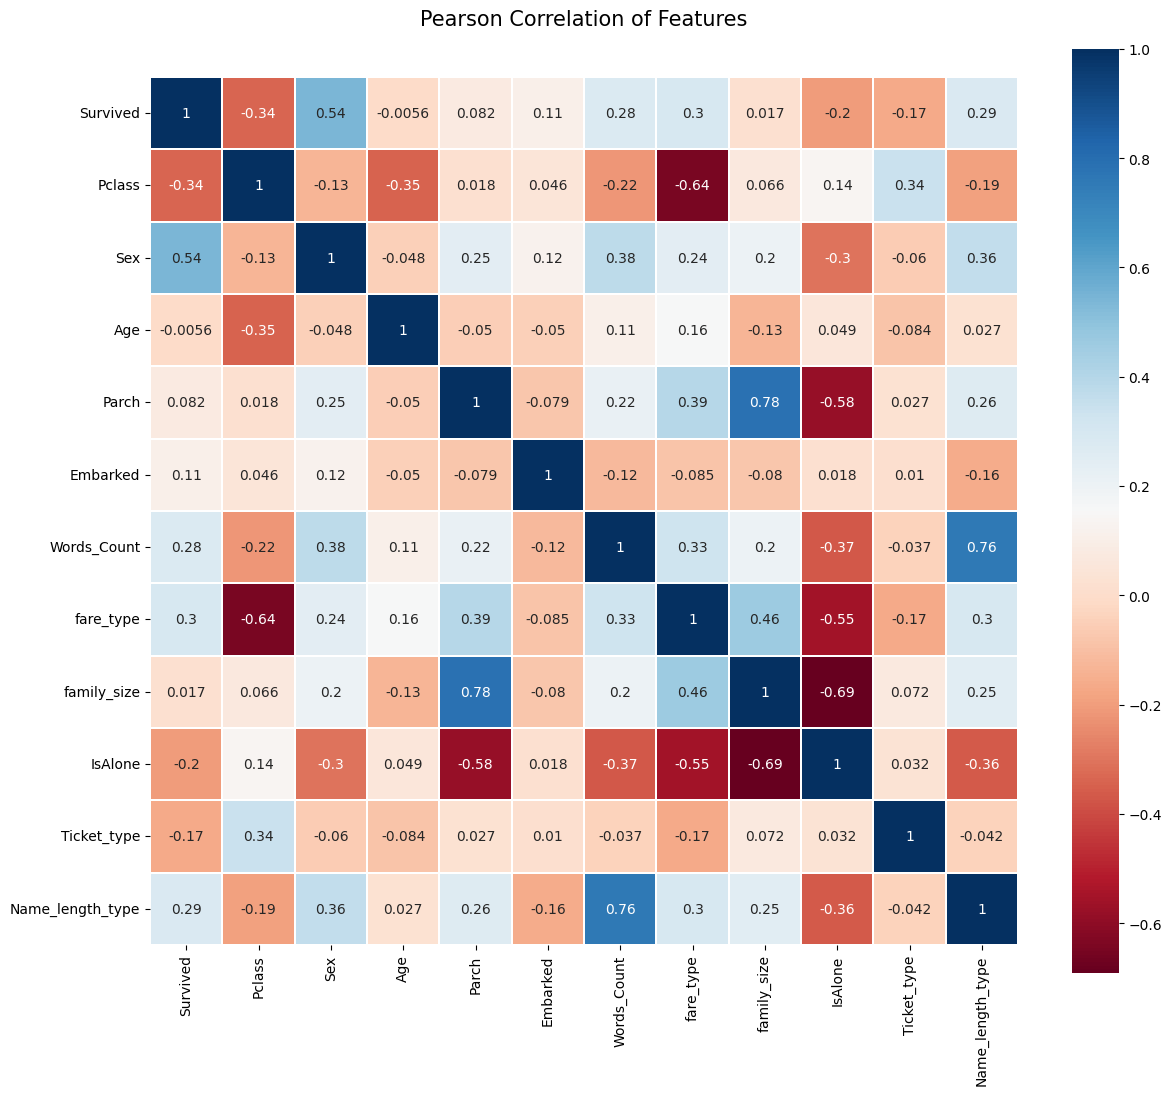

In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns

colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train_df.astype(float).corr(),linewidths=0.1,vmax=1.0,
            square=True, cmap=colormap, linecolor='white', annot=True)
plt.show()

In [ ]:

# Extracting the target variable and converting it into a one-dimensional array
y_train = train_df['Survived'].ravel()

# Removing the 'Survived' column from the train_df DataFrame
train_df = train_df.drop(['Survived'], axis=1)

# Converting the remaining features into a two-dimensional array
x_train = train_df.values

# Converting the features in the test_df DataFrame into a two-dimensional array
x_test = test_df.values

In [ ]:
gbm = xgb.XGBClassifier(
    #learning_rate = 0.02,
 n_estimators= 2000,
 max_depth= 4,
 min_child_weight= 2,
 #gamma=1,
 gamma=0.9,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread= -1,
 scale_pos_weight=1).fit(x_train, y_train)
xgb_predictions = gbm.predict(x_test)

In [ ]:
test_df

,Pclass,Sex,Age,Parch,Embarked,Words_Count,fare_type,family_size,IsAlone,Ticket_type,Name_length_type
0,3,0,2,0,2,3,0,1,1,58,0
1,3,1,3,0,0,5,0,2,0,71,3
2,2,0,3,0,2,4,1,1,1,32,1
3,3,0,1,0,0,3,1,1,1,55,0
4,3,1,0,1,0,6,1,3,0,54,3
...,...,...,...,...,...,...,...,...,...,...,...
413,3,0,1,0,0,3,1,1,1,96,0
414,1,1,3,0,1,5,3,1,1,107,2
415,3,0,3,0,0,4,0,1,1,113,2
416,3,0,1,0,0,3,1,1,1,70,0


In [ ]:
output = pd.DataFrame({'PassengerId': PassengerId, 'Survived': xgb_predictions})
output.to_csv('/content/drive/MyDrive/titanic/submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


In [ ]:
submission = pd.read_csv('/content/drive/MyDrive/titanic/submission.csv')
submission.tail()

,PassengerId,Survived
413,1305,0
414,1306,1
415,1307,0
416,1308,0
417,1309,0
